# Intent Classification with Small Transformers

In recent years, the transformer has been the go-to model in Natural Language Processing for almost all NLP tasks. Pretrained transformer models are easily available, but they are often large and fairly slow, which can make them hard to deploy. That's why a variety of smaller transformer models have emerged, which aim to compete with their bigger rivals, but at a lower computational cost. In this notebook we'll explore some of these smaller transformers. 

## Intent classification

We'll evaluate a range of pretrained transformer models on intent classification. Intent classification is a crucial task in the development of chatbots, where the computer needs to figure out how to respond to the input of a user. An interesting example dataset is `banking77`, which is available in the `datasets` library. It contains 13,083 customer service queries from the banking domain: 10,003 for training and 3080 for testing. Since there are 77 intents, it's a fairly challenging dataset.

In [1]:
from datasets import load_dataset

dataset = load_dataset('banking77')
dataset

Couldn't find file locally at banking77/banking77.py, or remotely at https://raw.githubusercontent.com/huggingface/datasets/1.4.1/datasets/banking77/banking77.py.
The file was picked from the master branch on github instead at https://raw.githubusercontent.com/huggingface/datasets/master/datasets/banking77/banking77.py.
Using custom data configuration default
Reusing dataset banking77 (/home/yves/.cache/huggingface/datasets/banking77/default/1.1.0/17ffc2ed47c2ed928bee64127ff1dbc97204cb974c2f980becae7c864007aed9)


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

The intents cover a wide variety of banking topics, from `pin_blocked` to `declined_transfer` and `terminate_account`.

In [2]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=77, names=['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival', 'card_delivery_estimate', 'card_linking', 'card_not_working', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'card_swallowed', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'change_pin', 'compromised_card', 'contactless_not_working', 'country_support', 'declined_card_payment', 'declined_cash_withdrawal', 'declined_transfer', 'direct_debit_payment_not_recognised', 'disposable_card_limits', 'edit_personal_details', 'exchange_charge', 'exchange_rate', 'exchange_via_app', 'extra_charge_on_statement', 'failed_transfer', 'fiat_currency_support', 'get_disposa

The user inputs themselves are fairly short: they're questions like "What can I do if my card still hasn't arrived after 2 weeks?" or "How do I know if I will get my card, or if it is lost?" Every item has one label, which makes this a straightforward single-label classification task.

In [3]:
for item in dataset["train"]["text"][:5]:
    print(item)

I am still waiting on my card?
What can I do if my card still hasn't arrived after 2 weeks?
I have been waiting over a week. Is the card still coming?
Can I track my card while it is in the process of delivery?
How do I know if I will get my card, or if it is lost?


Let's take a look at the distribution of the labels. Many text classification problems are hard, not only because of the number of labels, but also because of their skewed distribution. Fortunately, the situation in the `banking77` dataset is not too bad: there's a handful of infrequent labels, but overall, the skew in the distribution is not very pronounced.

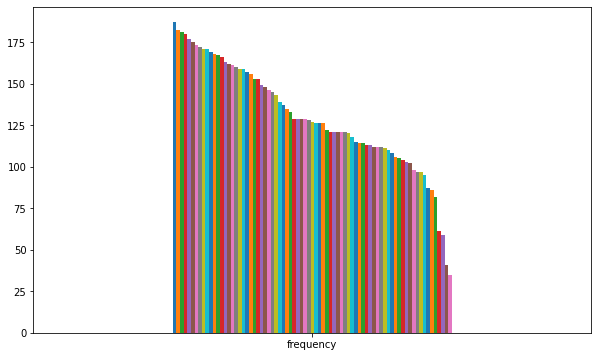

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

train_texts = [item["text"] for item in dataset["train"]]
train_labels = [item["label"] for item in dataset["train"]]

test_texts = [item["text"] for item in dataset["test"]]
test_labels = [item["label"] for item in dataset["test"]]

label_counter = Counter(train_labels)
label_names = dataset["train"].features["label"].names
label_frequencies = {label_names[label]: [label_counter[label]] for label in label_counter}

df = pd.DataFrame.from_dict(label_frequencies, orient="index", columns=["frequency"])
df = df.sort_values("frequency", ascending=False)

plt.rcParams['figure.figsize'] = (10,6)
ax = df.transpose().plot(kind="bar", rot=0)
ax.get_legend().remove()

## Data preparation

Before we start training, we need to take a few preparatory steps. First of all, we set aside 10% of the training data as our development (or validation) set, which we'll use to evaluate the performance of the models during training. We keep the test set intact.

In [5]:
from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels = train_test_split(train_texts, 
                                                                    train_labels, 
                                                                    test_size=0.1, 
                                                                    shuffle=True, 
                                                                    random_state=1)

print("Train:", len(train_texts))
print("Dev:", len(dev_texts))
print("Test:", len(test_texts))

Train: 9002
Dev: 1001
Test: 3080


Next, we define a dataset class to wrap the data in. When the model trainer gets an item from this class, it returns all information in the encoding (the token ids, the mask ids, etc.), together with the label.

In [6]:
import torch

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

Finally, we define the metrics that we'll evaluate the models with. As this is a single-label classification task, we'll simply compute the overall accuracy of the model output.

In [7]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }

## Smaller transformers

We evaluate two types of small transformer models: ALBERT, and a family of smaller BERT models.
    
ALBERT was introduced in the paper [ALBERT: A Lite BERT for Self-supervised Learning of Language Representations](https://arxiv.org/abs/1909.11942). It uses various insights to shrink the footprint of a BERT model:

- In contrast to models like BERT and XLNet, it decouples the size of the token embeddings from the size of the hidden layer. This allows it to have a much smaller embedding layer, and therefore, a more efficient model.
- It further reduces BERT's memory requirements by sharing all parameters across layers. 

Finally, in pretraining, the original next-sentence prediction task is replaced by a sentence order prediction task, where the model has to decide whether two sentences are presented in their original order, or whether the order has been swapped. This obviously has no effect on the size or speed of the model, but is a more challenging pretraining task that forces the model to focus more on sentence coherence and not just sentence topic.

While the original BERT has 108M parameters, ALBERT-base has just 12M and ALBERT-large has 18M.

Another type of smaller BERT models was presented in the paper [Well-Read Students Learn Better: On the Importance of Pre-training Compact Models](https://arxiv.org/abs/1908.08962). The researchers combine pretraining with model distillation to train smaller models:

- In a first step, a compact model is pretrained using the well-known masked language modeling objective.
- In a second step, these small student models are further trained on the label probabilities (the so-called soft labels) that are produced by a larger teacher model.

We'll test models with four different sizes: BERT-tiny (4.4M parameters), BERT-mini (11.3M parameters), BERT-small (29.1M parameters), and BERT-medium (41.7M parameters). 

## Model training

We use the `transformer` library to train and evaluate all models. We train every model for 3 epochs with a batch size of 16, and evaluate every 50 steps. At the end of every training cycle, we evaluate the best checkpoint on the test data and remember the accuracy. 

In [8]:
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification

model_ids = ["prajjwal1/bert-tiny", "prajjwal1/bert-mini", 
             "prajjwal1/bert-small", "prajjwal1/bert-medium",
             "albert-base-v2", "albert-large-v2", "bert-base-uncased"]

accuracies = []
for model_id in model_ids:
    
    print(f"*** {model_id} ***")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=len(label_names))

    train_texts_encoded = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
    dev_texts_encoded = tokenizer(dev_texts, padding=True, truncation=True, return_tensors="pt")
    test_texts_encoded = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
    
    train_dataset = ClassificationDataset(train_texts_encoded, train_labels)
    dev_dataset = ClassificationDataset(dev_texts_encoded, dev_labels)
    test_dataset = ClassificationDataset(test_texts_encoded, test_labels)
    
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=int(len(train_dataset)/16),
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="steps",
        eval_steps=50,
        save_steps=50,
        save_total_limit=10,
        load_best_model_at_end=True,
        no_cuda=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
    )

    trainer.train()
    test_results = trainer.evaluate(test_dataset)
    
    accuracies.append(test_results["eval_accuracy"])

*** prajjwal1/bert-tiny ***


Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
50,No log,4.356461,0.008991,0.065900,15195.764000
100,No log,4.353720,0.008991,0.065500,15283.272000
150,No log,4.348154,0.008991,0.065500,15283.606000
200,No log,4.341264,0.008991,0.064500,15514.941000
250,No log,4.333517,0.010989,0.065500,15290.230000
300,No log,4.324213,0.011988,0.066200,15131.741000
350,No log,4.313622,0.032967,0.065100,15380.241000
400,No log,4.296056,0.043956,0.065100,15378.382000
450,No log,4.269078,0.062937,0.064600,15485.300000
500,4.340500,4.240679,0.089910,0.064900,15433.386000


*** prajjwal1/bert-mini ***


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
50,No log,4.375497,0.004995,0.138200,7243.961000
100,No log,4.363358,0.005994,0.138600,7220.825000
150,No log,4.340960,0.017982,0.139000,7199.355000
200,No log,4.316107,0.032967,0.138400,7230.662000
250,No log,4.277944,0.038961,0.138500,7228.658000
300,No log,4.215641,0.060939,0.138600,7222.341000
350,No log,4.135591,0.123876,0.139000,7203.011000
400,No log,4.013452,0.223776,0.138700,7216.779000
450,No log,3.882334,0.304695,0.138900,7204.123000
500,4.221700,3.747517,0.382617,0.139300,7187.917000


*** prajjwal1/bert-small ***


Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
50,No log,4.369976,0.011988,0.381300,2625.318000
100,No log,4.329698,0.014985,0.380700,2629.636000
150,No log,4.270380,0.034965,0.379800,2635.807000
200,No log,4.176816,0.080919,0.380100,2633.286000
250,No log,4.009062,0.184815,0.379200,2639.936000
300,No log,3.775931,0.272727,0.379100,2640.235000
350,No log,3.519529,0.351648,0.381300,2625.066000
400,No log,3.236091,0.403596,0.379800,2635.468000
450,No log,2.936636,0.491508,0.380600,2629.989000
500,3.897200,2.664321,0.578422,0.382800,2614.888000


*** prajjwal1/bert-medium ***


Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
50,No log,4.354683,0.011988,0.751100,1332.642000
100,No log,4.303425,0.022977,0.752100,1330.895000
150,No log,4.216712,0.060939,0.751700,1331.691000
200,No log,4.050876,0.136863,0.753500,1328.548000
250,No log,3.809948,0.279720,0.752200,1330.726000
300,No log,3.496346,0.448551,0.750200,1334.291000
350,No log,3.193066,0.435564,0.752000,1331.061000
400,No log,2.877696,0.562438,0.751200,1332.489000
450,No log,2.577512,0.632368,0.751100,1332.728000
500,3.709300,2.288523,0.629371,0.752600,1330.052000


*** albert-base-v2 ***


Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
50,No log,4.359170,0.012987,2.666800,375.360000
100,No log,4.305244,0.021978,2.669800,374.940000
150,No log,4.244161,0.038961,2.670000,374.911000
200,No log,4.155644,0.055944,2.673300,374.445000
250,No log,3.990192,0.117882,2.673400,374.431000
300,No log,3.659245,0.192807,2.672500,374.559000
350,No log,3.335208,0.267732,2.673400,374.423000
400,No log,2.964495,0.349650,2.674200,374.317000
450,No log,2.594313,0.441558,2.675700,374.108000
500,3.684500,2.198615,0.540460,2.673500,374.412000


*** albert-large-v2 ***


Some weights of the model checkpoint at albert-large-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You s

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
50,No log,4.368546,0.013986,8.373100,119.550000
100,No log,4.306966,0.039960,8.377100,119.492000
150,No log,4.267850,0.036963,8.377800,119.482000
200,No log,4.124138,0.026973,8.374300,119.532000
250,No log,3.876354,0.105894,8.377200,119.492000
300,No log,3.503984,0.214785,8.377100,119.492000
350,No log,3.135200,0.256743,8.374300,119.533000
400,No log,2.851930,0.313686,8.377700,119.484000
450,No log,2.501250,0.435564,8.371400,119.574000
500,3.621500,2.241581,0.451548,8.370400,119.588000


*** bert-base-uncased ***


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
50,No log,4.396853,0.014985,2.295000,436.175000
100,No log,4.372972,0.019980,2.293300,436.483000
150,No log,4.224295,0.039960,2.292200,436.701000
200,No log,4.035959,0.100899,2.292800,436.591000
250,No log,3.747108,0.222777,2.290100,437.102000
300,No log,3.381693,0.370629,2.290800,436.974000
350,No log,2.986459,0.455544,2.289600,437.197000
400,No log,2.600285,0.571429,2.291300,436.861000
450,No log,2.234993,0.627373,2.291100,436.902000
500,3.563900,1.875070,0.705295,2.289100,437.295000


Let's take a look at the results. It's no surprise that BERT-base-uncased emerges as the best model: larger models have some clear advantages to their smaller competitors. At the other end of the spectrum, BERT-tiny and BERT-mini are definitely too small for this task. Still, the four models in the middle prove fairly strong competitors to BERT. The accuracy of BERT-small is around 6% lower than that of BERT, but BERT-medium is less than 3% behind. ALBERT is even closer, with ALBERT-base landing at less than 1.5% below the accuracy of the much larger BERT. In environments where there is not sufficient memory to run a full BERT, ALBERT-base may prove a very effictive solution indeed.

                          model
prajjwal1/bert-tiny    0.349351
prajjwal1/bert-mini    0.631169
prajjwal1/bert-small   0.861364
prajjwal1/bert-medium  0.892857
albert-base-v2         0.907468
albert-large-v2        0.904545
bert-base-uncased      0.920779


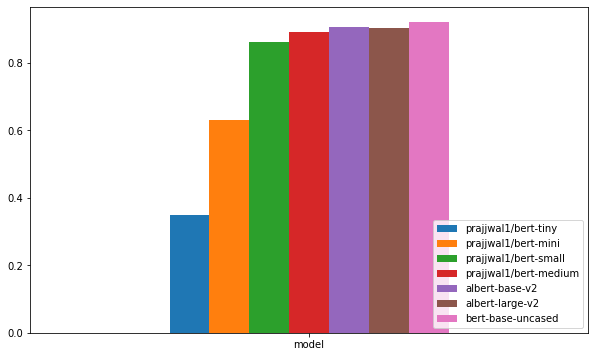

In [9]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"model": accuracies}, index=model_ids)

print(df)
plt.rcParams['figure.figsize'] = (10,6)
ax = df.transpose().plot(kind="bar", rot=0)
ax.legend(loc=4)

## Conclusions

The huge transformer models that have become so popular in NLP, are often hard to deploy. Sometimes they're too slow to process enormous amounts of data cost-effectively, sometimes they need more memory than is available. In this notebook, we've explored some more efficient transformer models. An evaluation on intent classification shows that they can often hold their own against their larger competitors. 